In [1]:
# Import libs
import pandas as pd  
import random as rnd
import numpy as np
import seaborn as sns #
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import tree # home of the dt classifier. Importing tree brings viz tools with it
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline # use pipeline to manage application of transforms during preprocessing and cross-validation 

from scipy import stats # for significance testing

# ignore sklearn warnings about the small class sizes in the arr dataset during fitting
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', FutureWarning)

In [2]:
# set seed for reproducible results
seed = 1234
np.random.seed(seed)

# set of alternative missing values that aren't implicitly coerced to "NaN"
alt_missing_vals = ["?","-","_"," ","n/a","nan","."]

**Data processing and analysis functions**

In [3]:
# preprocess data
def pre_processing(df):
    # get all column names in the same case and strip white space. Important for "Class" vs "class" and "class" vs " class"
    df.columns = df.columns.str.lower().str.strip()
    return df

# function to wrap all dataset statistics and prep functions
def review_data(df, df_name):
    print("starting on dataset: ",df_name)
    print("Missing values found: ",missingness(df))
    print("Collecting dataframe attributes...")
    df_attr = df_get_attr(df, df_name)
    print(df_name, " Done", '\n')
    return df_attr


# get aggregate statistics for a dataset 
def df_get_attr(df, df_name):
    # create dict to store results
    results = dict()
    # create another dict to store any cols that need review e.g. cols with hidden missing values. 
    # Better to review these than just drop/replace blindly
    to_review = dict()
    
    # run functions to extract meta data
    
    # get attributes for each col e.g. date type, unique values...
    col_attr = df_get_col_attr(df)
    # dataset name
    results["dataset"] = df_name
    # nrows
    results["nrows"] = df.shape[0]
    # ncols
    results["ncols"] = df.shape[1]

    # missing values
    results["missing_vals"] = sum(df.isnull().sum())
    
    # hidden missing values. These are values that infer NaN but are not picked up by pandas
    results["hidden_missing_vals"] = 0
    # if there are any such cols we want a list to review
    to_review["hidden_missing_vals"] = []
    for i in col_attr:
        # compare col vals with the set of alternative missing values (see constants section)
        if any([j in alt_missing_vals for j in col_attr[i]["unique_vals"]]) == True:
            # count cols with issues
            results["hidden_missing_vals"] +=1
            # store any cols found for later review
            to_review["hidden_missing_vals"].append(i)            
            
            
    
    # columns with no signal
    results["no_signal_cols"] = 0
    # if there are any such cols we want a list to review
    to_review["no_signal_cols"] = []
    for i in col_attr:
        if col_attr[i]["unique_val_count"] < 2: # columns with 1 value contain no signal
            # count cols with issues
            results["no_signal_cols"] +=1
            # store any cols found to review / drop
            to_review["no_signal_cols"].append(i) 
            
    # count of target classes
    results["classes"] = df["class"].unique().size
    return results, to_review


# find missing values in the form of NaNs
def missingness(df):
    missing_vals_count = sum(df.isnull().sum())
    return missing_vals_count

# get attributes for each column in a dataset
def df_get_col_attr(df):
    col_attr = dict()
    for i in df.columns:
        x = dict()
        #i["col_name"] = i
        x["type"] = df.dtypes[i]
        x["unique_val_count"] = df[i].unique().size
        x["unique_vals"] = sorted(df[i].unique())
        col_attr[i] = x
    return col_attr

**Begin Preprocessing**

In [4]:
# import data sets
bcp_raw = pd.read_csv("BCP.csv") # (683,11), no NaN values
web_raw = pd.read_csv("website-phishing.csv") # (11055,31), no NaN values
arr_raw = pd.read_csv("arrhythmia.csv") # (452, 280), no NaN values

# preprocess data sets to standardise lower case and target column name 
# give data sets a name to store results against
bcp = pre_processing(bcp_raw)
bcp.name = 'bcp'
web = pre_processing(web_raw)
web.name = 'web'
arr = pre_processing(arr_raw)
arr.name = 'arr'

dataset_list = [bcp,web,arr]

# generate an initial overview of the datasets using the preprocessing functions
bcp_review = review_data(bcp, bcp.name)
web_review = review_data(web, web.name)
arr_review = review_data(arr, arr.name)

starting on dataset:  bcp
Missing values found:  0
bcp  Done 

starting on dataset:  web
Missing values found:  0
web  Done 

starting on dataset:  arr
Missing values found:  0
arr  Done 



In [5]:
# create dataframe to store results
combined_review = pd.concat([pd.DataFrame(bcp_review[0], index = [0])
                            ,pd.DataFrame(web_review[0], index = [0])
                            ,pd.DataFrame(arr_review[0], index = [0])]
                            ,ignore_index = True)
combined_review

,dataset,nrows,ncols,missing_vals,hidden_missing_vals,no_signal_cols,classes
0,bcp,683,11,0,0,0,2
1,web,11055,31,0,0,0,2
2,arr,452,280,0,5,17,13


**General observations on summary above:**
1. bcp and arr are short datasets
1. arr has high dimensionality
1. there are no explicit missing values
1. bcp and web are binary classification problems while arr is a multiclass classification problem
1. arr has 5 columns with values that might be NaN but not explicitly NaN (see "hidden_missing_vals" column)
1. arr has 17 columns that have a single value for all rows. These should be dropped (see "no_signal_cols" column)

**Start by addressing the arrhythmia dataset issues**

In [6]:
# list the columns with hidden missing values 
arr_review[1]["hidden_missing_vals"]

['t', 'p', 'qrst', 'j', 'heartrate']

In [7]:
# what are these hidden missing values?
vals = set()
for col in arr_review[1]["hidden_missing_vals"]:
    for val in arr[col]:
        if val in alt_missing_vals:
            vals.add(val)
vals

{'?'}

...that's convenient, all suspicious columns contain "?". Lets remove those values and convert the cols to numeric...

In [8]:
# drop non-numeric values after checking they are missing values. Use errors="coerce" to replace non-numeric with "NaN"
for col in arr_review[1]["hidden_missing_vals"]:
    arr[col] = pd.to_numeric(arr[col], errors="coerce")
    # convert data type
    arr[col].astype("Int64")

# then drop cols with no signal
arr.drop(columns = arr_review[1]["no_signal_cols"], inplace=True)    

...now resolve the missing data

In [9]:
# find the columns with missing values...
arr.isnull().sum().sort_values(ascending=False).head(6)

j                  376
p                   22
t                    8
heartrate            1
qrst                 1
chavr_spwaveamp      0
dtype: int64

The missing values are only in the 5 columns we found earlier.

1. Col "j": 92% of the data is missing. The column is too sparse to be of any use so we'll drop this
1. Col "p": 5% of the data is missing. There may be enough data to make the column useful.
1. Col "t", "heartrate" and "qrst": <5% of the data is missing. There may be enough data to make these columns useful

Lets review the content of these columns. We'll also look at their class association as there are often rare classes in a multiclass classification problems.

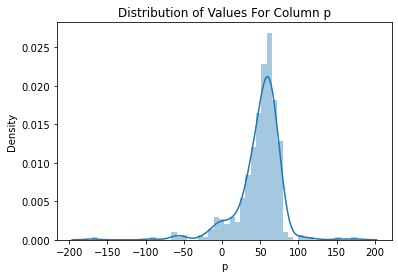

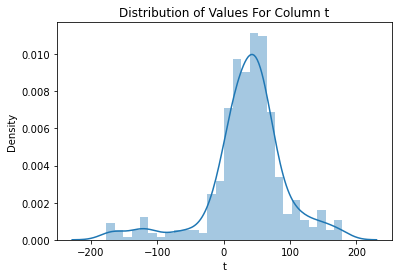

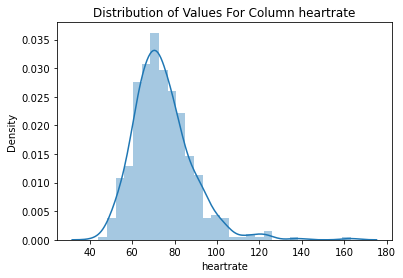

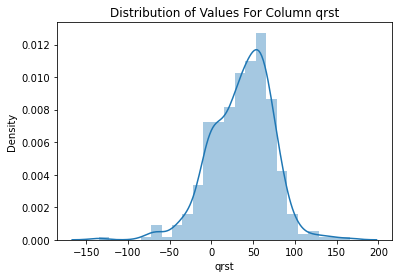

In [10]:
# drop column "j"
arr.drop(columns = "j", inplace=True)

# remaining columns to review

cols_missing_vals = ["p","t","heartrate","qrst"]

# column content
for col in cols_missing_vals:
    plt.figure(col)
    sns.distplot(arr[col]).set(title='Distribution of Values For Column {}'.format(col))

<Figure size 432x288 with 0 Axes>

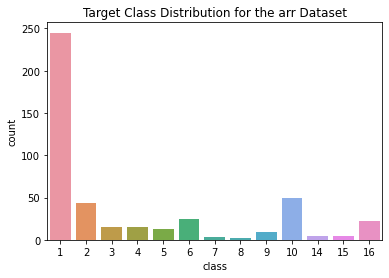

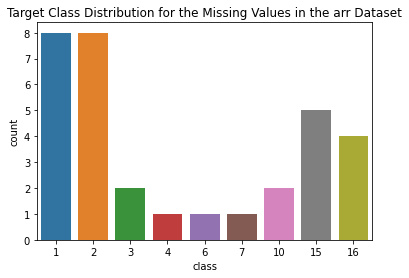

<Figure size 432x288 with 0 Axes>

In [11]:
# what is the target class distribution?
sns.countplot(arr['class']).set(title='Target Class Distribution for the arr Dataset')
plt.figure()
# what is the distribution of classes for the missing values?
sns.countplot(arr[arr.isnull().any(axis=1)]["class"]).set(title='Target Class Distribution for the Missing Values in the arr Dataset')
plt.figure()

**Analysis of missing values**

Classes are broadly distributed across the incomplete rows. This covers rare classes like 4, 7 and 15. Deleting instances of already rare classes may be a loss of too much information. Instead we'll replace the missing values with an imputation method which will be discussed in the modelling section. 

!!! we wait until after splitting to apply imputation to not leak test information into our train data

### Imputation Strategy

Simple imputation options include replacing the missing values with a global or local constant such as mean, median, mode or  generating a random value from the distribution. A more complicated method is learning models from the complete cases to predict the missing values in incomplete cases.

This experiment will implement a simple method, local mean imputation, as the missing values are:
1. a small percentage of the dataset so the effect on cross feature relationships is more likely to be small and 
2. the affected columns contain somewhat normally distributed data

Other imputation options include predicting the missing values based on the other predictors or combining that with an incremental imputer that iteratively resolves columns from most to least complete

In [12]:
# run imputation in the pipeline so it occurs on the splits avoiding leakage
numeric_imputer_mean = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))])

# Split Data, Prep Model

Tree pre-prunning and hyperparameter tuning are done concurrently in the following functions.

The next section estabishes the functions used to:
1. Split data
1. Transform splits (imputation only)
1. Build models
1. Evaluate models
1. Functions to wrap these all into a single call

**Functions to build the model workflow**

In [13]:
# take a prepared dataframe, seperate the features (X) from the target (y) and create an 80/20 split stratified by target
def get_splits(dataset, seed, random=False):
    if random:
        random_state = None
    else:
        random_state = seed
        
    X = dataset.drop(['class'], axis=1)
    y = dataset['class']   
    # stratify as the classes are imbalanced and we want that imbalance to be consistent across splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, stratify=y)
    return X_train, X_test, y_train, y_test

In [14]:
# master function to call "build_eval_models" for each dataset and model type combination. Organises the results for analysis
def get_results(datasets, transformer, seed, random, bcp_alpha=0.0, web_alpha=0.0, arr_alpha=0.0):
    # set up dict to store results
    results = {} 
    models = {}
    # for each dataset, create and evaluate the models of interest: stump, unpruned, pre-pruned and post-pruned models
    for i in datasets:
        # dict to store the model results
        i_results_dict = {}
        # dict to store the "best" version of each dataset:model type combination
        i_models_dict = {}
        
        # report the start of dataset processing
        print("Starting on dataset: ", i.name)
        
        # save the results for the decision stump and the best model for each dataset
        i_results_dict['stump_results'],i_models_dict['stump_models']=build_eval_models(i, 'decision stump', transformer, seed, random)
        
        # save the results for the unpruned decision tree and the best model for each dataset
        i_results_dict['unpruned_dt_results'],i_models_dict['unpruned_dt_models']=build_eval_models(i, 'unpruned dt', transformer, seed, random)
        
        # save the results for the prepruned decision tree and the best model for each dataset
        i_results_dict['prepruned_dt_results'], i_models_dict['prepruned_dt_models']=build_eval_models(i, 'prepruned dt', transformer, seed, random)

        # define the cost complexity parameter alpha based on the dataset. This begins with default 0 and refined in Task 5
        # TODO: clean this up
        if i.name == 'bcp':
            alpha = bcp_alpha
        elif i.name == 'web':
            alpha = web_alpha
        elif i.name == 'arr':
            alpha = arr_alpha
        # save the results for the postpruned decision tree and the best model for each dataset
        i_results_dict['postpruned_dt_results'], i_models_dict['postpruned_dt_models']=build_eval_models(i, 'postpruned dt', transformer, seed, random, ccp_alpha=alpha)
        
        # report end  
        print(i.name, " complete")
        
        # update dicts
        results[i.name] = i_results_dict
        models[i.name] = i_models_dict
    # combine results for analysis (whereas we just save the models for later use)
    results_all_datasets = pd.concat([pd.DataFrame.from_dict(results['bcp'], orient="index")
                                      ,pd.DataFrame.from_dict(results['web'], orient="index")
                                      ,pd.DataFrame.from_dict(results['arr'], orient="index")]
                                    )
    return results_all_datasets, models

In [15]:
# function that builds each model type required. Output is a store of the best version for each dataset
def build_eval_models(dataset, model_type, transformer, seed, random=False, ccp_alpha=0.0, n_jobs=-1, verbose=0):
    if random:
        random_state = None
    else:
        random_state = seed
    models = dict()
    
    # set up dict to store model results to make predictions etc.
    results = dict()
    
    # save name of dataset
    results['dataset'] = dataset.name
    models['dataset'] = dataset.name
    
    # save name of model type
    results['model_type'] = model_type    
    models['model_type'] = model_type
    
    # get labelled splits
    X_train, X_test, y_train, y_test = get_splits(dataset, seed, random)
    
    # get classifier for the model_type
    dt = get_classifier(model_type, seed, random, ccp_alpha)

    # define pipeline for the model type
    pipe = Pipeline(steps=[('numeric_prep', transformer), 
                           ('classifier', dt)])
    
    # get parameters for this model type
    params = get_params(model_type)

    # set up cross validation. Stratified as some datasets have class imbalance and shuffled in case the dataset is ordered in some way
    # outer is 5 fold cross validation while inner will seperate model selection from model evaluation in nested cross validation
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=None) # random so inner folds differ to outer folds
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)    
    
    # standard grid search with 5 fold cross validation. 
    search_standard = GridSearchCV(pipe, params, cv=outer_cv, verbose=verbose, n_jobs=n_jobs)
    fit_search_standard = search_standard.fit(X_train, y_train)

    # save results from k-fold cv
    results['kfold best mean cv score'] = round(fit_search_standard.best_score_, 4)
    models['kfold best model'] = fit_search_standard
 

    # this section applies nested cross validation to contrast with standard cross validation
   
    search_nested_cv = GridSearchCV(pipe, params, cv=inner_cv, verbose=verbose, n_jobs=n_jobs)  
    fit_search_nested = search_nested_cv.fit(X_train, y_train)
    nested_train_scores = cross_val_score(search_nested_cv, X_train, y_train, scoring='accuracy', cv=outer_cv, n_jobs=n_jobs)

    # save the results from nested cv
    results['nested best mean cv score'] = round((np.mean(nested_train_scores)),4)
    models['nested best model'] = fit_search_nested

    results['kfold test pred acc'] = round(fit_search_standard.score(X_test, y_test), 4)
    results['nested test pred acc'] = round(fit_search_nested.score(X_test, y_test), 4)
    
    # approximation error using mean cv performance
    results['kfold approx error'] = results['kfold test pred acc']-results['kfold best mean cv score']
    results['nested approx error'] = results['nested test pred acc']-results['nested best mean cv score']
    
    # list best params from the standard search. We can compare the hyperparameters selected across datasets 
    for i in fit_search_standard.best_params_:
        results[i] = fit_search_standard.best_params_.get(i)    
    
    return results, models

In [16]:
# define classifier for each use case. Enable the option to run with the defined seed or with randomness 
def get_classifier(model_type, seed, random=False, ccp_alpha=None):
    if random:
        random_state = None
    else:
        random_state = seed
        
    # decision stumps have a single split so depth of 1
    if model_type == 'decision stump':
        dt = tree.DecisionTreeClassifier(random_state=random_state, max_depth=1)
    # post prunning requires the cost complexity parameter alpha
    elif model_type == 'postpruned dt':
        dt = tree.DecisionTreeClassifier(random_state=random_state, ccp_alpha=ccp_alpha)
    # for all other model types use the base decision tree 
    else:
        dt = tree.DecisionTreeClassifier(random_state=random_state)
    return dt

In [17]:
# get hyperparameters to search based on the model type
# internally specifies the set of hyperparamer values to search over
def get_params(model_type):
    # splitting criterion
    criterion = ['entropy','gini']
    
    # max splits allowed. Initial trials returned 20 as the best on some datasets so set the max depth slightly higher to verify this. 
    max_depth = [1,2,4,6,10,20,25]   
    
    # min samples to allow in each split and in each leaf as min_samples_split can still result in overfitting small leaves
    min_samples_sizes = [2,5,10,20,30,50]
    
    # pre pruning parameters
    if model_type == 'prepruned dt':
        params = dict(classifier__criterion = criterion,
                      classifier__max_depth = max_depth,
                      classifier__min_samples_split = min_samples_sizes,                
                      classifier__min_samples_leaf = min_samples_sizes
                      )
    
    # for all other model types we only tune criterion so as to distinquish between Task 2 (pre-pruning) and Task 5 (post-pruning) 
    else:
        params = dict(classifier__criterion = criterion)
    return params   

# Discussion
### Hyperparameters & Tunning Strategies Chosen

Decision tree hyperparameters offer options for optimizing the splitting metric and controlling the complexity of the model. The splitting metric is the measure used to locally optimise splits. The remaining hyperparameters control the complexity of the model by either pre-prunning or post-prunning the model.

Hyperparameters can be tuned using brute force or through a learning processes. The brute force approaches are grid search, where the author attempts to cover the parameter space, and random search. Grid search is usually well spaced but potentially biased by the author while random search may land on an optimum combination by chance. 

In contrast, learning is an iterative process. In each iteration the parameter space is sampled and results measured. The approach moves away from poor performing subspaces. Learning processes may find "better" parameters by refining the search to promising subspace(s) but can be more computationally expensive.

For this assignment I have chosen to apply grid search with pre-prunning in task 2 and post-prunning in task 5. The target models are very simple so the performance improvement from more complex methods is likely to be insignificant.

**Pre-prunning Strategy**

I will evaluate three pre-prunning hyperparameters:
1. _max_depth_: the maximum depth (sequential splits) the tree can grow to
1. _min_samples_split_: a minimum constraint on the samples in each split
1. _min_samples_leaf_: a minimum constraint on the number of samples in leaf nodes

We use both _min_samples_split_ and _min_samples_leaf_ as the former hyperparameter can generate unexpectedly small leaf nodes which the latter hyperparameter can control against. It is unclear if such an issue exists in this dataset but the simplicity of the model negates any concerns about the computational complexity of an extra hyperparameter. 

### Cross Validation Strategy

We apply cross validation to optimise the bias-variance trade off. I will evaluate two strategies:
1. k-fold cross validation
1. Nested cross validation

k-fold cross validation utilises the same folds for model selection and model evaluation. Cawley et al* point out the risks of this approach as information is "leaked" during model selection. They propose model selection be independent of model evaluation by executing each on different cross validation sets. 

The results of this "nested cross validation" approach suggest fold counts as low as 2 are effective. Whereas the recommendation for k-fold cross validation 5-10 folds. However, it should be noted that the results also indicated that as the number of folds (and presumably data size) increased, k-fold cross validation often performed as well as nested cross validation on test sets but the mean performance in nested cross validation was a more accurate approximation of test performance. 

An "inner_cv" of 5 folds will be used for model selection in nested cross validation
An "outer_cv" of 5 folds will be used for model evaluation in nested cross validation and also used for selection and evaluation in k-fold cross validation

We choose k = 5 for the inner fold as this performed better than smaller k values in the randomised experiments. We choose k = 5 for the outer cross validation because of the shorter datasets.

*ref: Cawley et al, 2010, https://jmlr.csail.mit.edu/papers/volume11/cawley10a/cawley10a.pdf

In [18]:
# Get a baseline results
task2_results, task2_models = get_results(datasets=dataset_list, transformer=numeric_imputer_mean, seed=seed, random=False)

Starting on dataset:  bcp
bcp  complete
Starting on dataset:  web
web  complete
Starting on dataset:  arr
arr  complete


In [19]:
# results from baseline test
task2_results

,dataset,model_type,kfold best mean cv score,nested best mean cv score,kfold test pred acc,nested test pred acc,kfold approx error,nested approx error,classifier__criterion,classifier__max_depth,classifier__min_samples_leaf,classifier__min_samples_split
stump_results,bcp,decision stump,0.9340,0.9213,0.8978,0.8978,-0.0362,-0.0235,entropy,NaN,NaN,NaN
unpruned_dt_results,bcp,unpruned dt,0.9706,0.9541,0.9197,0.9197,-0.0509,-0.0344,entropy,NaN,NaN,NaN
prepruned_dt_results,bcp,prepruned dt,0.9707,0.9633,0.9124,0.8978,-0.0583,-0.0655,entropy,6.0,2.0,10.0
postpruned_dt_results,bcp,postpruned dt,0.9706,0.9596,0.9197,0.9197,-0.0509,-0.0399,entropy,NaN,NaN,NaN
stump_results,web,decision stump,0.8899,0.8899,0.8851,0.8851,-0.0048,-0.0048,entropy,NaN,NaN,NaN
unpruned_dt_results,web,unpruned dt,0.9599,0.9593,0.9652,0.9652,0.0053,0.0059,entropy,NaN,NaN,NaN
prepruned_dt_results,web,prepruned dt,0.9517,0.9518,0.9584,0.9593,0.0067,0.0075,entropy,20.0,2.0,5.0
postpruned_dt_results,web,postpruned dt,0.9599,0.9587,0.9652,0.9652,0.0053,0.0065,entropy,NaN,NaN,NaN
stump_results,arr,decision stump,0.5846,0.5818,0.6154,0.6154,0.0308,0.0336,gini,NaN,NaN,NaN
unpruned_dt_results,arr,unpruned dt,0.6205,0.6205,0.6154,0.6154,-0.0051,-0.0051,gini,NaN,NaN,NaN


## Results Discussion

**Performance**

Casting our eye down the "test pred acc" column the decision stump model performs the worst on all three datasets although it ties for worst on the arr dataset. The decision stump has a single decision node and it appears the classes of each dataset can be better seperated by more than 1 split. However, the decision stumps do have the lowest training error of the bcp and web datasets. The single split as less likely to overfit.

The training error for nested cross validation is geneally lower than standard cross validation suggesting seperating model selection from model evaluation can return a better approximation of test performance.

Of the prepruned models only the arr dataset performed better. In the bcp and web datasets preprunning performance was slightly below the unprunned tree which is not expected as preprunning should reduce the risk of over fitting returning a model that better generalises to test data.

**Hyperparameters**

The web dataset resulted in the deepest tree (20) followed by arr (10). Web had the largest dataset size. The depth may be a result of there being more patterns to split on because of that. Alternatively, because the stump model has a similar accuracy to the other model types, it may be that there is one dominant feature to split on and after that it takes many subsequent splits to delineate between the two classes. The arr dataset is wide so I expected it to produce the deepest tree but perhaps it was affected by the breadth of classes and the dominance of class 1.

The pre-prunning hyperparameters varried across datasets. The minimum samples in leaf nodes was low with all datasets returning 5 or fewer samples as the constraint. The arr dataset had the highest value and this may be due to the minority classes being difficult to seperate. If they could be seperated we would expect to see a min leaf size of 2 (especially with some cv folds containing fewer than 5 samples of each class).

The min samples in each split are lower for the web dataset and higher for bcp and arr. I suspect the higher value in the arr dataset is again due to the prevelance of class 1 and a difficulty to seperate the other classes. The splits are probably just learning how to seperate class 1 as that will dominate the accuracy metric.

Entropy was the optimum splitting metric on the bcp and web datasets. The optimum splitting metric on the arr dataset varied by model type. Entropy is slightly more computationally intensive than Gini but this is not a consideration for the scale of these datasets. Entropy may also scale up small probabilities and this could be relevant on the minority classes in the arr dataset and explain why Gini was returned for arr. But generally, performance is expected to be equivalent between the two metrics in all but rare cases as reported by Raileanu and Stoffel so we do not read into these results. We also see that in task 5 and again in the experiment re-runs the optimum splitting metric chosen is not consistent. 

*ref: Raileanu, L; Stoffel, K - Theoretical comparison between the Gini Index and Information Gain criteria

## Compare Methods for Statistically Significant Differences

In [21]:
# use the best models from k-fold cross validation from tasks 2 and 3 to generate the p-values of the significance tests
def get_p_vals(models, dataset, seed, nested=False):
    
    if nested == True:
        cv = 'nested best model' # return the best models for nested cross validation
    else:
        cv = 'kfold best model' # return the best models for standard cross validation
    
    # get labelled splits
    X_train, X_test, y_train, y_test = get_splits(dataset, seed, random=False)
    
    # set lists to save outputs
    dataset_p = [] 
    model_i = []
    model_j = []
    p_value = []
    
    # for each non-duplicate model pair, get test predictions and save p values
    for i in range(0,len(models[dataset.name])):
        
        # get the name of the model 
        modeli = list(models[dataset.name])[i]
    
        # get test predictions for that model
        rsv1 = models[dataset.name][modeli][cv].predict(X_test) 
         
        # now get all other (non-duplicate) models to compare to
        for j in range(i + 1, len(models[dataset.name])):
        
            # get the next model name
            modelj = list(models[dataset.name])[j]
           
            # Get test predictions for that model
            rsv2 = models[dataset.name][modelj][cv].predict(X_test)
            
            # Calculate and store p value for the significance test of the two models
            p = stats.ttest_rel(rsv1, rsv2)[1]
            p_value.append(round(p, 5))

            # save labels for the comparison
            dataset_p.append(dataset.name)
            model_i.append(modeli)
            model_j.append(modelj)            
            
    # convert all results to dataframe for anlaysis
    df = pd.DataFrame(list(zip(dataset_p, model_i, model_j, p_value), ), columns =['dataset', 'model one', 'model two', 'p value']) 
    return df

In [22]:
# generate p-values
p_val_df_list = [get_p_vals(task2_models, i, seed, nested=False) for i in dataset_list]
p_val_df = pd.concat(p_val_df_list, ignore_index=True).sort_values(['dataset','p value'], ascending = True)
p_val_df 

#NB: NaN where predictions are identical

,dataset,model one,model two,p value
13,arr,stump_models,prepruned_dt_models,0.00001
12,arr,stump_models,unpruned_dt_models,0.00010
14,arr,stump_models,postpruned_dt_models,0.00010
15,arr,unpruned_dt_models,prepruned_dt_models,0.17500
17,arr,prepruned_dt_models,postpruned_dt_models,0.17500
16,arr,unpruned_dt_models,postpruned_dt_models,NaN
0,bcp,stump_models,unpruned_dt_models,0.00717
2,bcp,stump_models,postpruned_dt_models,0.00717
1,bcp,stump_models,prepruned_dt_models,0.01786
3,bcp,unpruned_dt_models,prepruned_dt_models,0.31909


**Discussion**

The stump models for the bcp and arr datasets were the only models to **significantly** perform worse than other models based on a 95% confidence level. While the stump model of the web dataset did perform noticeably worse than comparisons according to test accuracy, the difference does not pass the significance test. That difference in performance may be due to chance.

This underperformance is probably the result of single node trees (stumps) generally underfitting vs trees with multiple decision nodes. Deeper trees are generally better able to divide the model space and delineate between classes.

# Task 5

1. Use a different pruning strategy to task 2: used post pruning
1. Compare the effects of the two different pruning strategies on the three datasets: see discussion section
1. Explain your findings and discuss the possible reasons: see discussion section


**Post-Prunning Strategy**

For post-prunning I will use the cost complexity criterion _ccp_alpha_. This parameter balances the trade off between the tree's cost (e.g. accuracy) and its complexity (depth). As alpha increases, the tree's complexity decreases. When alpha is max we have a decision stump.

**Compare Prunning Techniques**

Pre-prunning reduces the risk of over fitting by limiting fidelity of the splits to the training data. For example, an unprunned tree can grow to the point where leaf nodes contain a single, or very few, samples. This may create a tree that does not generalise to data beyond the training set. In contrast, post-prunning allows the tree to grow as greedly as it improves the splitting criterion. The approach then retrospectively evaluates the splits created and prunes the splits that do not decrease the accuracy on the validation set.

In [23]:
# evaluate alpha values using cross validation
# code adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py
def get_best_alpha(dataset, decision_tree, seed, random=False):
    if random:
        random_state = None
    else:
        random_state = seed
    
    # dt
    clf = decision_tree
    # splits
    X_train, X_test, y_train, y_test = get_splits(dataset, seed, random)
    
    # mean imputation
    imp = SimpleImputer(strategy='mean')
    X_train = pd.DataFrame(imp.fit_transform(X_train))
    X_test = pd.DataFrame(imp.fit_transform(X_test))
    
    # track the decision tree path for the classifier based X, y
    # unfortunately we have to call the method with X, y. Would be nice to call it with the best unpruned decision tree from earlier
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    
    # from the path determine the best pruning points and the associated change in cost if pruned
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    
    mean, dataset_name = [], []
    for i in ccp_alphas:
        clf = tree.DecisionTreeClassifier(random_state=random_state, ccp_alpha=i)
        # 5 fold cross validation for each alpha value
        scores = cross_val_score(clf, X_train, y_train, cv=5)
        # store mean from cv
        mean.append(scores.mean())
        dataset_name.append(dataset.name)
        
    # save the values of alpha, mean and standard deviation of accuracy
    df = pd.DataFrame({'dataset': dataset_name, 'alpha': ccp_alphas, 'mean': mean})
    df = df.sort_values(['dataset','mean'], ascending = False)
    
    return df

<AxesSubplot:xlabel='alpha', ylabel='mean'>

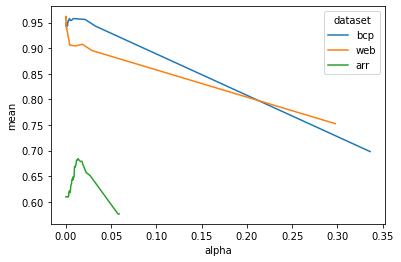

In [24]:
# get alpha values and mean accuracy for each dataset
alpha_val_df_list = [get_best_alpha(i, get_classifier(model_type='unpruned dt', seed=seed, random=False), seed=seed, random=False) for i in dataset_list]
alpha_val_df = pd.concat(alpha_val_df_list, ignore_index=True)    

# visualise the alpha values. 
sns.lineplot('alpha','mean', hue='dataset', data=alpha_val_df)

In [25]:
# find the alpha values with the lowest mean cv accuracy for each dataset
alpha_val_df.loc[alpha_val_df.groupby('dataset')['mean'].idxmax()]

,dataset,alpha,mean
239,arr,0.013617,0.684170
0,bcp,0.008256,0.957882
15,web,0.000084,0.962348


In [26]:
# looks like the optimum values are...
arr_alpha = 0.013617
bcp_alpha = 0.008256
web_alpha = 0.000084

In [27]:
# now lets generate our models and comparison again
task5_results, task5_models = get_results(datasets=dataset_list, transformer=numeric_imputer_mean, seed=seed, random=False, bcp_alpha=bcp_alpha, web_alpha=web_alpha, arr_alpha=arr_alpha) 

Starting on dataset:  bcp
bcp  complete
Starting on dataset:  web
web  complete
Starting on dataset:  arr
arr  complete


In [28]:
task5_results

,dataset,model_type,kfold best mean cv score,nested best mean cv score,kfold test pred acc,nested test pred acc,kfold approx error,nested approx error,classifier__criterion,classifier__max_depth,classifier__min_samples_leaf,classifier__min_samples_split
stump_results,bcp,decision stump,0.9340,0.9231,0.8978,0.8978,-0.0362,-0.0253,entropy,NaN,NaN,NaN
unpruned_dt_results,bcp,unpruned dt,0.9706,0.9688,0.9197,0.9197,-0.0509,-0.0491,entropy,NaN,NaN,NaN
prepruned_dt_results,bcp,prepruned dt,0.9707,0.9505,0.9124,0.9416,-0.0583,-0.0089,entropy,6.0,2.0,10.0
postpruned_dt_results,bcp,postpruned dt,0.9688,0.9616,0.9270,0.9270,-0.0418,-0.0346,entropy,NaN,NaN,NaN
stump_results,web,decision stump,0.8899,0.8899,0.8851,0.8851,-0.0048,-0.0048,entropy,NaN,NaN,NaN
unpruned_dt_results,web,unpruned dt,0.9599,0.9593,0.9652,0.9616,0.0053,0.0023,entropy,NaN,NaN,NaN
prepruned_dt_results,web,prepruned dt,0.9517,0.9514,0.9584,0.9593,0.0067,0.0079,entropy,20.0,2.0,5.0
postpruned_dt_results,web,postpruned dt,0.9599,0.9605,0.9638,0.9611,0.0039,0.0006,entropy,NaN,NaN,NaN
stump_results,arr,decision stump,0.5846,0.5679,0.6154,0.6154,0.0308,0.0475,gini,NaN,NaN,NaN
unpruned_dt_results,arr,unpruned dt,0.6205,0.6205,0.6154,0.6154,-0.0051,-0.0051,gini,NaN,NaN,NaN


In [29]:
# for each model pair, compare p-values on the test data. 
# This helps us identify where performance differences are probably significant vs chance 
p_val_df_list_task5 = [get_p_vals(task5_models, i, seed, nested=False) for i in dataset_list]
p_val_df_task5 = pd.concat(p_val_df_list_task5, ignore_index=True)
p_val_df_task5 = p_val_df_task5.sort_values(['dataset','p value'], ascending = True)
p_val_df_task5 

,dataset,model one,model two,p value
13,arr,stump_models,prepruned_dt_models,0.00001
14,arr,stump_models,postpruned_dt_models,0.00001
12,arr,stump_models,unpruned_dt_models,0.00010
16,arr,unpruned_dt_models,postpruned_dt_models,0.09920
15,arr,unpruned_dt_models,prepruned_dt_models,0.17500
17,arr,prepruned_dt_models,postpruned_dt_models,0.52680
0,bcp,stump_models,unpruned_dt_models,0.00717
4,bcp,unpruned_dt_models,postpruned_dt_models,0.00768
5,bcp,prepruned_dt_models,postpruned_dt_models,0.01376
1,bcp,stump_models,prepruned_dt_models,0.01786


<AxesSubplot:xlabel='dataset', ylabel='kfold test pred acc'>

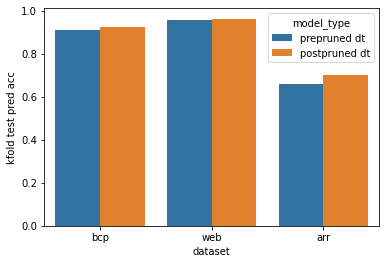

In [30]:
# visualise the difference in performance on test metrics
task5_prunned_dts = task5_results.loc[task5_results['model_type'].isin(['prepruned dt', 'postpruned dt'])]
sns.barplot('dataset','kfold test pred acc', hue='model_type', data=task5_prunned_dts)

**Discussion**

The web dataset has the lowest alpha value which is interesting as it has the deepest model of all datasets. It therefore has more "opportunities" to prune. It may be that prunning does not improve the accuracy OR that it does not improve the accuracy of the majority class (web has imbalanced classes) and that is dominating the overall accuracy measure.

The arr dataset has a larger alpha than the bcp dataset which we might expect as arr (10) is almost twice the depth of bcp (6) and has more classes. 

The post-pruned models were the best performers on the arr and bcp datasets. It was also a very close second on the web dataset. But we find this performance difference is not significant at the 95% confidence level. We conclude the improved performance is chance.  

Comparing the two prunning strategies, the performance on the test set was very similar for bcp and web datasets but somewhat higher for the post-pruned tree on the arr dataset. Again though, that higher performance difference on the arr dataset is not significant at the 95% confidence level with a p value of 0.52.

It appears pre-prunning and post-prunning are equally effective for these datasets. I would guess that post pruning is generally going to be less effective with classification trees. This is because the output of the model is based on the majority class of the leaf nodes. Therefore, any prunning has to significantly alter the class mix in a leaf node before there is any change in the output.

If I were to build the experiment again I would incorporate a metric that evaluates accuracy for imbalanced classes e.g. Matthews Correlation Coefficient

# Multiple Model Runs

Now re-run the experiment 5 times with randomness. Doing so provides a broader view of model performance as we test the models over different cv splits and holdout test sets. This is like an additional cross validation but including randomness. Consistency in accuracy between experiments will suggest the models can generalise. We can interpret inconsistency as an opportunity to improve.

In [31]:
# generate 5 experiments. Set the seed so each experiment is trained on the same folds,
# but vary the seed between experiments

exp1_results, exp1_models = get_results(datasets=dataset_list, transformer=numeric_imputer_mean, seed=1, random=False, bcp_alpha=bcp_alpha, web_alpha=web_alpha, arr_alpha=arr_alpha) 
exp2_results, exp2_models = get_results(datasets=dataset_list, transformer=numeric_imputer_mean, seed=2, random=False, bcp_alpha=bcp_alpha, web_alpha=web_alpha, arr_alpha=arr_alpha) 
exp3_results, exp3_models = get_results(datasets=dataset_list, transformer=numeric_imputer_mean, seed=3, random=False, bcp_alpha=bcp_alpha, web_alpha=web_alpha, arr_alpha=arr_alpha) 
exp4_results, exp4_models = get_results(datasets=dataset_list, transformer=numeric_imputer_mean, seed=4, random=False, bcp_alpha=bcp_alpha, web_alpha=web_alpha, arr_alpha=arr_alpha) 
exp5_results, exp5_models = get_results(datasets=dataset_list, transformer=numeric_imputer_mean, seed=5, random=False, bcp_alpha=bcp_alpha, web_alpha=web_alpha, arr_alpha=arr_alpha) 

exp1_results['experiment'] = 1
exp2_results['experiment'] = 2
exp3_results['experiment'] = 3
exp4_results['experiment'] = 4
exp5_results['experiment'] = 5

Starting on dataset:  bcp
bcp  complete
Starting on dataset:  web
web  complete
Starting on dataset:  arr
arr  complete
Starting on dataset:  bcp
bcp  complete
Starting on dataset:  web
web  complete
Starting on dataset:  arr
arr  complete
Starting on dataset:  bcp
bcp  complete
Starting on dataset:  web
web  complete
Starting on dataset:  arr
arr  complete
Starting on dataset:  bcp
bcp  complete
Starting on dataset:  web
web  complete
Starting on dataset:  arr
arr  complete
Starting on dataset:  bcp
bcp  complete
Starting on dataset:  web
web  complete
Starting on dataset:  arr
arr  complete


In [32]:
# results and models for 5x experiment
exp1to5_model_list = [exp1_models,exp2_models,exp3_models,exp4_models,exp5_models]
exp1to5_list = [exp1_results,exp2_results,exp3_results,exp4_results,exp5_results]
exp1to5_df = pd.concat(exp1to5_list, ignore_index=True)
exp1to5_df.head()

,dataset,model_type,kfold best mean cv score,nested best mean cv score,kfold test pred acc,nested test pred acc,kfold approx error,nested approx error,classifier__criterion,classifier__max_depth,classifier__min_samples_leaf,classifier__min_samples_split,experiment
0,bcp,decision stump,0.9212,0.9212,0.9197,0.9197,-0.0015,-0.0015,gini,NaN,NaN,NaN,1
1,bcp,unpruned dt,0.9378,0.9341,0.9343,0.9343,-0.0035,0.0002,entropy,NaN,NaN,NaN,1
2,bcp,prepruned dt,0.9487,0.9433,0.9489,0.9489,0.0002,0.0056,entropy,6.0,5.0,20.0,1
3,bcp,postpruned dt,0.9415,0.9341,0.9489,0.9635,0.0074,0.0294,entropy,NaN,NaN,NaN,1
4,web,decision stump,0.8899,0.8899,0.8851,0.8851,-0.0048,-0.0048,entropy,NaN,NaN,NaN,1


[Text(0.5, 1.0, 'Performance of CV Strategies')]

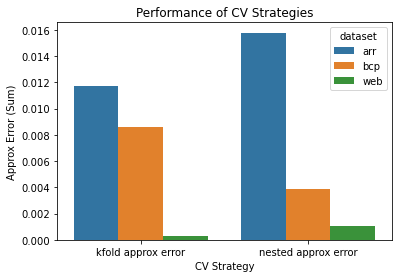

In [33]:
# compare the cross validation strategies
kfold_approx_error_df = exp1to5_df.groupby('dataset')['kfold approx error'].mean().abs().reset_index()
nest_approx_error_df = exp1to5_df.groupby('dataset')['nested approx error'].mean().abs().reset_index()
compare_cv_strategies_df = pd.concat([kfold_approx_error_df, nest_approx_error_df.drop('dataset', axis=1)], axis=1)
compare_cv_strategies_df = compare_cv_strategies_df.melt(id_vars='dataset', var_name='CV Strategy', value_name='Approx Error (Sum)')
sns.barplot('CV Strategy','Approx Error (Sum)', hue='dataset', data=compare_cv_strategies_df).set(title='Performance of CV Strategies')

[Text(0.5, 1.0, 'Hyperparameter Ranges Over 5 Experiments')]

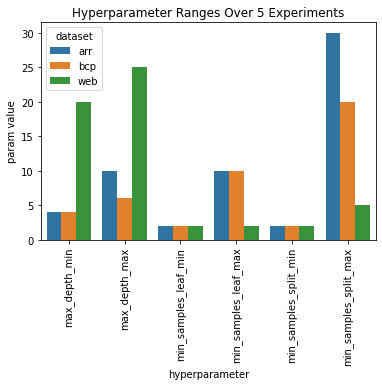

In [34]:
# Compare the range for each hyperparameter over each dataset
hyper_df = exp1to5_df[exp1to5_df['model_type'] == 'prepruned dt'].groupby('dataset').agg(
    max_depth_min=pd.NamedAgg(column='classifier__max_depth', aggfunc=min),
    max_depth_max=pd.NamedAgg(column='classifier__max_depth', aggfunc=max),
    min_samples_leaf_min=pd.NamedAgg(column='classifier__min_samples_leaf', aggfunc=min),
    min_samples_leaf_max=pd.NamedAgg(column='classifier__min_samples_leaf', aggfunc=max),
    min_samples_split_min=pd.NamedAgg(column='classifier__min_samples_split', aggfunc=min),
    min_samples_split_max=pd.NamedAgg(column='classifier__min_samples_split', aggfunc=max),    
).reset_index()

compare_hyper_df = hyper_df.melt(id_vars='dataset', var_name='hyperparameter', value_name='param value')
plt.xticks(rotation=90)
sns.barplot('hyperparameter','param value', hue='dataset', data=compare_hyper_df).set(title='Hyperparameter Ranges Over 5 Experiments')

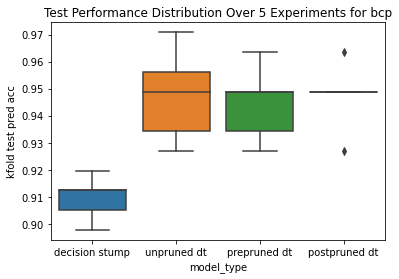

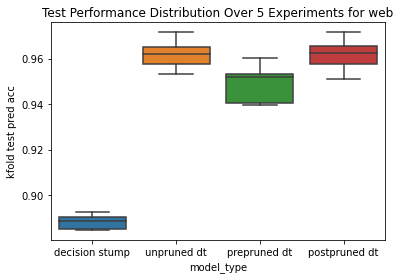

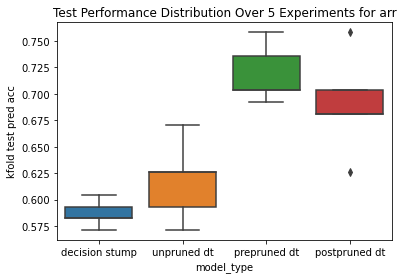

In [35]:
# visualise test performance over the 5 experiments 
for i in dataset_list:
    plt.figure()
    sns.boxplot('model_type','kfold test pred acc', data=exp1to5_df.loc[exp1to5_df['dataset'] == i.name]).set(title='Test Performance Distribution Over 5 Experiments for {}'.format(i.name))
    plt.show()

[Text(0.5, 1.0, 'Significance Test: Pre-Pruned vs Post-Pruned Over 5 Experiments')]

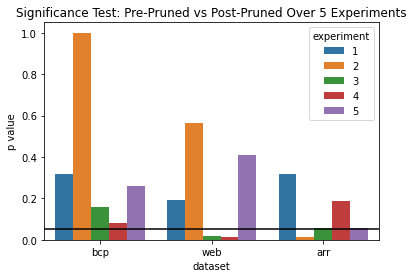

In [36]:
# evaluating whether a significant difference exists between each model type (per experiment)
p_val_df_list_exp1to5 = [get_p_vals(i, j, seed, nested=False) for i in exp1to5_model_list for j in dataset_list]
p_val_df_exp1to5 = pd.concat(p_val_df_list_exp1to5, ignore_index=False).reset_index()#.rename(columns={'index': 'experiment'})

# label experiments
conditions = [
    (p_val_df_exp1to5.index < 18),
    (p_val_df_exp1to5.index >= 18) & (p_val_df_exp1to5.index < 36),
    (p_val_df_exp1to5.index >= 36) & (p_val_df_exp1to5.index < 54),
    (p_val_df_exp1to5.index >= 54) & (p_val_df_exp1to5.index < 72),
    (p_val_df_exp1to5.index >= 72)
]
values = [1,2,3,4,5]
p_val_df_exp1to5['experiment'] = np.select(conditions, values)


# visualise the p value for each expirement and dataset for the pruned models
## get the pruned model significance tests
exp1to5_prunned_dts = p_val_df_exp1to5.loc[p_val_df_exp1to5['model one'] == 'prepruned_dt_models']
plt.axhline(0.05, color='black')
sns.barplot('dataset','p value', hue='experiment', data=exp1to5_prunned_dts).set(title='Significance Test: Pre-Pruned vs Post-Pruned Over 5 Experiments')


**Discussion**

We repeated the experiment 5 times each with a different seed. With this we can observe the consistency of performance rather than relying on the single experiment represented by tasks 2-5.

**_What can we say about the cross validation strategy?_** (see figure: Performance of CV Strategies)

For 2 of the 3 datasets, nested cross validation returned a better estimate of test peformance than kfold cross validation. The two approaches returned an equivalent estimate of test performance on the largest dataset: web. The largest dataset was also the one with the lowest approximation error. 

If we were building the experiment from scratch we could evaluate a train, test split on the web database in contrast to kfold cross validation

**_What can we say about the hyperparameters?_** (see figure: Hyperparameter Ranges Over 5 Strategies)

The selected, pre-prunned model varied for each dataset in each experiment. This suggests the grid search is being affected by the datasplit and that we have not identified an optimal set of hyperparameters. 

If we were building the experiment from scratch we could examine the GridSearch parameters for each dataset and gradually refine the search space in the hope of identifying a near optimal set of hyperparameters.


**_What can we say about the consistency of test performance?_** (see figures: Test Performance Distribution...)

I expected that test performance would be more consistent on longer datasets, like web, as there are usually more instances of each pattern/relationship in the training data. But the test performance varies. We cannot run significance tests as each experiment has a different seed and therefore a different test set distribution. But we might find that the approaches mentioned in cross validation and hyperparameter strategies above might improve the consistency.

Neither pruning strategy had consistent performance on any dataset. The variation in the pre-pruned trees on both bcp and arr may be a result of the size of these datasets. Being small, the training set in each fold may not be sufficient to learn as generalizable model as we see with the web dataset. If I were to build the experiment again I would contrast alternative splitting strategies on the bcp and arr datasets such as leave-one-out cv and train-validation-test splitting because of the size of these datasets.

**_What can we say about the two prunning strategies?_** (see figure: Significance Test...)

In task 5 we saw no significant difference in performance between pre and post pruning. Across the 5 experiment we see a significant difference can be observed. 2/5 experiments showed a significant difference on the web dataset (experiments 3 and 4) and 3/5 experiments showed a significant difference on the arr dataset (experiments 2, 3 and 5)